In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pandas as pd
from scipy.io import loadmat
from scipy.stats import binned_statistic

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from poglm import utils, inference, model, distributions

from importlib import reload
reload(model)

In [2]:
## arguments
vari_list = ['F', 'FS', 'FB']
distribution_list = np.array(['Poisson', 'categorical', 'GS-score', 'GS-pathwise', 'exponential', 'Rayleigh', 'half-normal'])
distribution_abbr_dict = {'Poisson': 'Pois', 'categorical': 'Cat', 'GS-score': 'GS-s', 'GS-pathwise': 'GS-p', 'exponential': 'Exp', 'Rayleigh': 'Ray', 'half-normal': 'HF'}
distribution_abbr_list = np.array(list(distribution_abbr_dict.values()))
n_hid_neurons_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
seed_list = np.arange(10)

In [17]:
df_list = []
for vari in vari_list:
    for distribution in distribution_list:
        for n_hid_neurons in n_hid_neurons_list:
            for seed in seed_list:
                try:
                    df_temp = pd.read_csv(f'csv/{vari}_{distribution}_{n_hid_neurons}_{seed}.csv')
                    df_temp['vari'] = vari
                    df_temp['distribution'] = distribution
                    df_temp['$n$ hidden neurons'] = n_hid_neurons
                    df_temp['seed'] = seed
                    df_list.append(df_temp)
                except:
                    print(vari, distribution, n_hid_neurons, seed)

    df = pd.concat(df_list, ignore_index=True)

ll_glm = pd.read_csv('csv/GLM.csv').at[0, 'marginal log-likelihood']

Text(0.02, 0.5, 'LL')

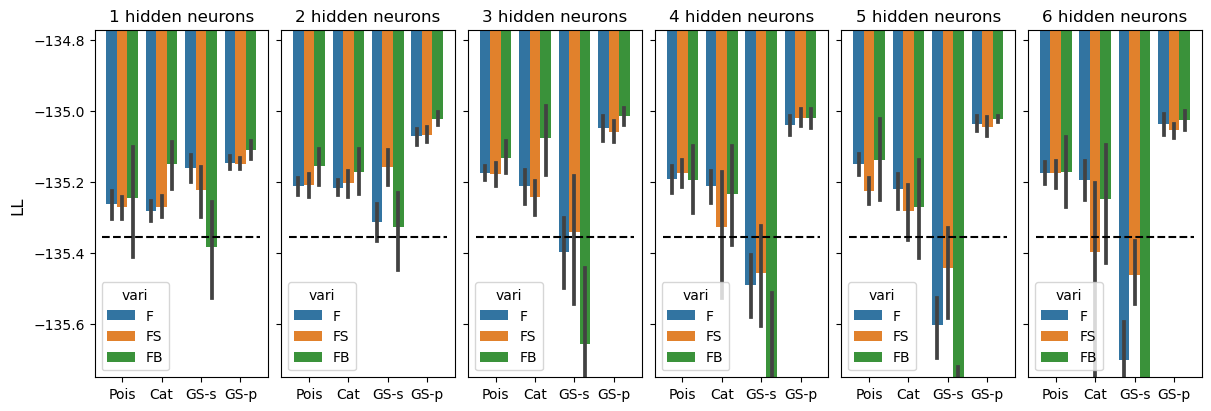

In [127]:
fig, axs = plt.subplots(1, len(n_hid_neurons_list), figsize=(12, 4), layout='constrained', sharex=True, sharey=True)
axs = axs.flat

for i, n_hid_neurons in enumerate(n_hid_neurons_list):
    ax = sns.barplot(x='distribution', y='marginal log-likelihood', hue='vari', data=df[df['$n$ hidden neurons'] == n_hid_neurons], ax=axs[i], order=distribution_abbr_dict.values(), hue_order=vari_list)
    
    ax.plot([-0.5, 3.5], [ll_glm, ll_glm], 'k--')
    ax.set(xlabel=None, ylabel=None, ylim=(-135.75, df['marginal log-likelihood'].max()), title=f'{n_hid_neurons} hidden neurons')
fig.supylabel('LL')

# fig.savefig(f'{folder}_metric.pdf')

In [12]:
df

,marginal log-likelihood,ELBO,time,vari,distribution,$n$ hidden neurons,seed
0,-135.328550,-135.725481,5.991823,F,Pois,1,0
1,-135.299110,-135.542589,5.684339,F,Pois,1,1
2,-135.209726,-135.518280,5.728645,F,Pois,1,2
3,-135.168498,-135.336189,5.730671,F,Pois,1,3
4,-135.229103,-135.539783,5.741510,F,Pois,1,4
...,...,...,...,...,...,...,...
1075,-135.021930,-135.449414,68.930091,FB,GS-p,9,5
1076,-135.059705,-135.419717,68.882616,FB,GS-p,9,6
1077,-135.027511,-135.442046,68.759037,FB,GS-p,9,7
1078,-135.100687,-135.578002,68.493586,FB,GS-p,9,8


/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/seaborn/_oldcore.py

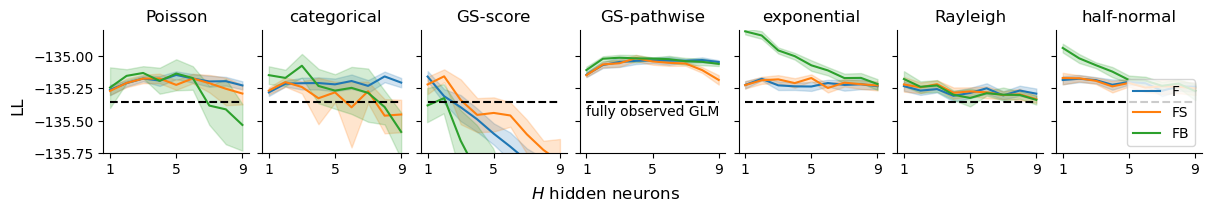

In [10]:
fig, axs = plt.subplots(1, len(distribution_list), figsize=(12, 2), layout='constrained', sharex=True, sharey=True)
axs = axs.flat

for i, distribution in enumerate(distribution_list):
    ax = sns.lineplot(x='$n$ hidden neurons', y='marginal log-likelihood', hue='vari', data=df[df['distribution'] == distribution], ax=axs[i], hue_order=vari_list)
    
    ax.plot([1, 9], [ll_glm, ll_glm], 'k--')
    ax.set(xlabel=None, ylabel=None, xticks=[1, 5, 9], ylim=(-135.75, -134.8), title=f'{distribution}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.supylabel('LL')
fig.supxlabel('$H$ hidden neurons')
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[3].get_legend().remove()
axs[4].get_legend().remove()
axs[5].get_legend().remove()
axs[6].get_legend().set(title=None, loc='lower right')
axs[3].text(1.0, -135.46, 'fully observed GLM')

fig.savefig(f'pvc-5.pdf')

In [34]:
n_hid_neurons = 9
n_neurons = n_vis_neurons + n_hid_neurons
seed = 1

In [35]:
x = loadmat(f'crcns-pvc5/rawSpikeTime/times_090425blk10_ch66.mat')['cluster_class']
timestamps_list = [x[x[:, 0] == i, 1] / 1000 for i in np.unique(x[:, 0])]
spikes = torch.from_numpy(utils.continuous_to_discrete(timestamps_list, dt=0.02, T=900)).to(torch.float32)


## hyper-parameters
decay = 0.25
window_size = 10
n_vis_neurons = spikes.shape[-1]
n_neurons = n_vis_neurons + n_hid_neurons
basis = utils.exp_basis(decay, window_size, window_size)


vis_spikes_list_train, vis_spikes_list_test = spikes[:22500].reshape(225, 100, -1), spikes[22500:].reshape(225, 100, -1)
convolved_vis_spikes_list_train = utils.convolve_spikes_with_basis(vis_spikes_list_train, basis, direction='forward')
convolved_vis_spikes_list_test = utils.convolve_spikes_with_basis(vis_spikes_list_test, basis, direction='forward')
rev_convolved_vis_spikes_list_train = utils.convolve_spikes_with_basis(vis_spikes_list_train, basis, 'backward')
rev_convolved_vis_spikes_list_test = utils.convolve_spikes_with_basis(vis_spikes_list_test, basis, 'backward')
train_dataset = TensorDataset(vis_spikes_list_train, convolved_vis_spikes_list_train, rev_convolved_vis_spikes_list_train)
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=False)

Text(0.5, 0.98, 'Learned $q$')

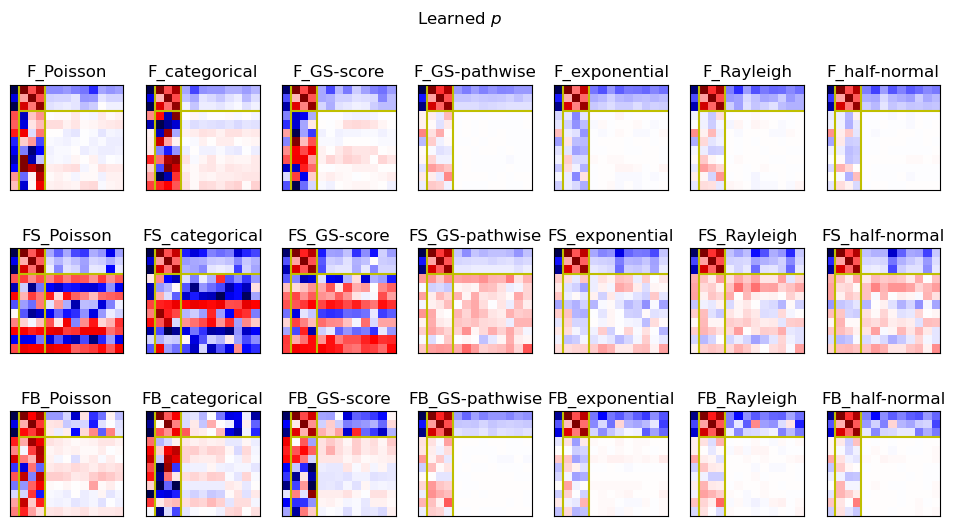

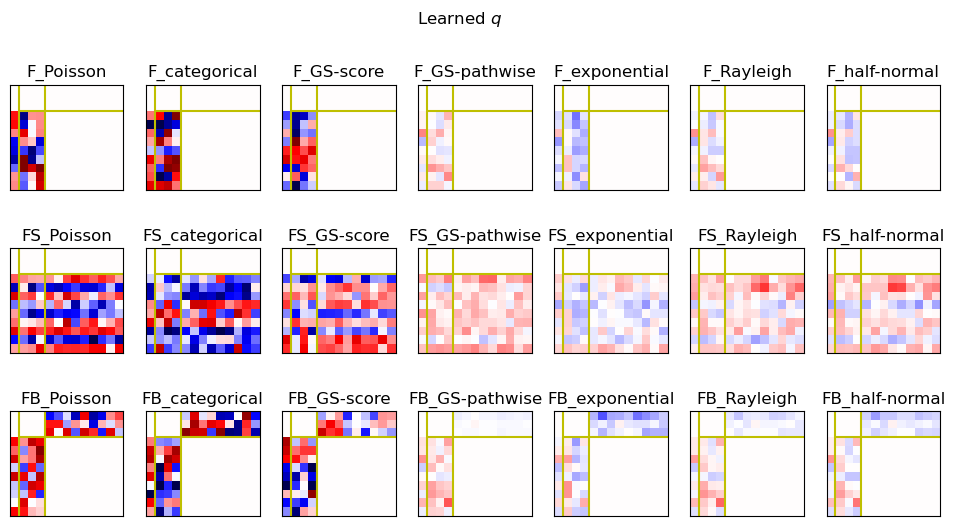

In [36]:
fig, axs = plt.subplots(len(vari_list), len(distribution_list), figsize=(12, 6))

for i, vari in enumerate(vari_list):
    for j, distribution in enumerate(distribution_list):
        try:
            w = torch.load(f'model/{vari}_{distribution}_{n_hid_neurons}_{seed}_inf.pt')
            im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)
            axs[i, j].set(title=f'{vari}_{distribution}')
        except:
            pass
fig.suptitle('Learned $p$')

fig, axs = plt.subplots(len(vari_list), len(distribution_list), figsize=(12, 6))

for i, vari in enumerate(vari_list):
    for j, distribution in enumerate(distribution_list):
        try:
            w = torch.load(f'model/{vari}_{distribution}_{n_hid_neurons}_{seed}_vari.pt')
            im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)
            axs[i, j].set(title=f'{vari}_{distribution}')
        except:
            pass
fig.suptitle('Learned $q$')

In [18]:
df_2 = df.copy()
df_2['marginal log-likelihood'] = df_2['marginal log-likelihood'] / (3 * 100)
ll_glm = ll_glm / (3 * 100)

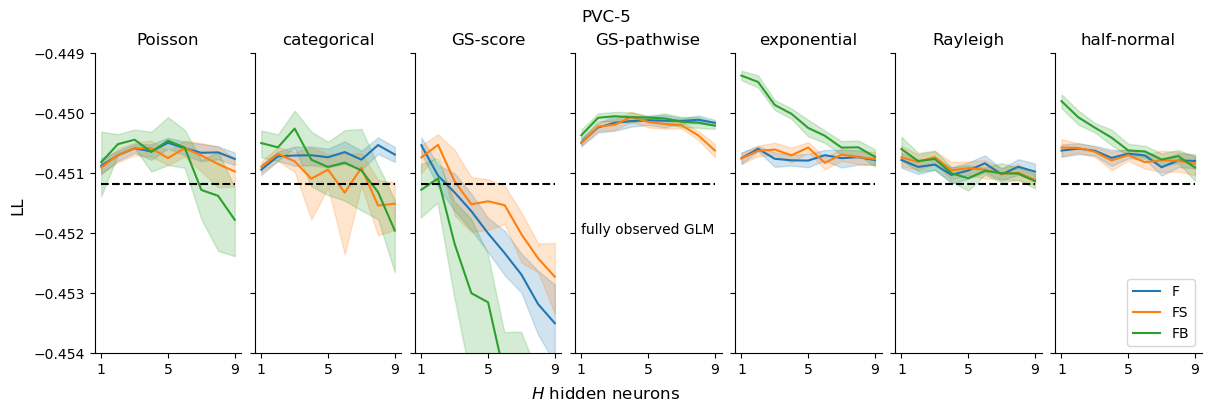

In [26]:
fig, axs = plt.subplots(1, len(distribution_list), figsize=(12, 4), layout='constrained', sharex=True, sharey=True)
axs = axs.flat

for i, distribution in enumerate(distribution_list):
    ax = sns.lineplot(x='$n$ hidden neurons', y='marginal log-likelihood', hue='vari', data=df_2[df_2['distribution'] == distribution], ax=axs[i], hue_order=vari_list)
    
    ax.plot([1, 9], [ll_glm, ll_glm], 'k--')
    ax.set(xlabel=None, ylabel=None, xticks=[1, 5, 9], ylim=(-0.454, -0.449), title=f'{distribution}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.supylabel('LL')
fig.supxlabel('$H$ hidden neurons')
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[3].get_legend().remove()
axs[4].get_legend().remove()
axs[5].get_legend().remove()
axs[6].get_legend().set(title=None, loc='lower right')
axs[3].text(1.0, -0.452, 'fully observed GLM')

fig.suptitle('PVC-5')
fig.savefig(f'pvc-5_CI.pdf', bbox_inches='tight', transparent=True)